In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import cv2
import os


In [2]:
# split the processed image into train, validation, test
# 90% (train & validation) 10% test
# 90% train 10% validation
def split_covid():
    data_covid = []
    data_covid_dir = "C:/Users/Vern Sin/Documents/Jupyter/CXR Classification/data/covid"
    for image in os.listdir(data_covid_dir):
        img_ary = cv2.imread(os.path.join(data_covid_dir, image))
        data_covid.append([img_ary, 0])
    
    X = []
    y = []
    for features, labels in data_covid:
        X.append(features)
        y.append(labels)
        
    X_com, X_test, y_com, y_test = train_test_split(X, y,test_size=0.1,random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_com, y_com,test_size=0.1,random_state=0)
    
    for i in range(len(X_train)):
        filename = "./training/"
        filename += "covid/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_train[i]))
        
    for i in range(len(X_val)):
        filename = "./validation/"
        filename += "covid/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_val[i]))
    
    for i in range(len(X_test)):
        filename = "./testing/"
        filename += "covid/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_test[i]))

In [3]:
# split_covid()

In [4]:
def split_health():
    data_health = []
    data_health_dir = "C:/Users/Vern Sin/Documents/Jupyter/CXR Classification/data/health"
    for image in os.listdir(data_health_dir):
        img_ary = cv2.imread(os.path.join(data_health_dir, image))
        data_health.append([img_ary, 0])
    
    X = []
    y = []
    for features, labels in data_health:
        X.append(features)
        y.append(labels)
        
    X_com, X_test, y_com, y_test = train_test_split(X, y,test_size=0.1,random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_com, y_com,test_size=0.1,random_state=0)
    
    for i in range(len(X_train)):
        filename = "./training/"
        filename += "health/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_train[i]))
        
    for i in range(len(X_val)):
        filename = "./validation/"
        filename += "health/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_val[i]))
    
    filename = "./testing/"
    for i in range(len(X_test)):
        filename = "./testing/"
        filename += "health/"+str(i)+".png"
        cv2.imwrite(filename, np.array(X_test[i]))

In [5]:
# split_health()

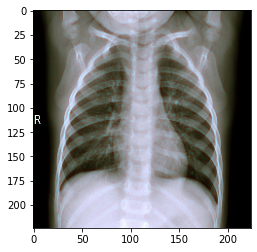

In [6]:
# just show an image
img_try = image.load_img("./training/health/3.png")
plt.imshow(img_try)

In [7]:
# check the size of the image (width, height, channel), channel should be equal to 3 since pseudo color image formation is done
cv2.imread("./training/health/3.png").shape

(224, 224, 3)

In [8]:
# get the training set from train directory, categorial is used since softmax is applied at the last layer, shuffle the training set too
train = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1)
training_data = train.flow_from_directory("./training/", target_size=(224,224), class_mode="categorical",shuffle=True)

X_train, y_train = training_data.next()

Found 2057 images belonging to 2 classes.


In [9]:
training_data.class_indices

{'covid': 0, 'health': 1}

In [10]:
# same, get the testing set from test directory
test = ImageDataGenerator()
testing_data = test.flow_from_directory("./testing/", target_size=(224,224), class_mode="categorical", subset="training",shuffle=True, batch_size=255)

X_test, y_test = testing_data.next()

Found 255 images belonging to 2 classes.


In [11]:
testing_data.class_indices

{'covid': 0, 'health': 1}

In [12]:
len(X_test)

255

In [13]:
# get the validation set from train directory, categorial is used since softmax is applied at the last layer, shuffle the training set too
validation = ImageDataGenerator()
validation_data = validation.flow_from_directory("./validation/", target_size=(224,224), class_mode="categorical",shuffle=True)

X_val, y_val = validation_data.next()

Found 229 images belonging to 2 classes.


In [14]:
# decay the learning rate every 5 epoch
def lr_time_based_decay(epoch, lr):
    if epoch % 5 == 0:
        return lr*0.8
    return lr

In [15]:
# define cnn model as designed, even it is binary class, softmax with one hot encoding is used (improved performance)
VGG = keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
VGG.trainable = False

model = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation="softmax")
])

In [16]:
# define some other parameters for cnn model, get the precision & recall (validation set is treated as test set) by using metrics
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

In [17]:
# training begin
hist = model.fit(X_train, y_train, batch_size=4, epochs=30, validation_data=(X_val, y_val),callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)], shuffle=True)

# hist = model.fit_generator(steps_per_epoch=4,generator=training_data, validation_data= testing_data,shuffle=True, validation_steps=10,epochs=200,callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])


Epoch 00001: LearningRateScheduler reducing learning rate to 7.999999797903002e-06.
Epoch 1/30
8/8 [==============================] - 18s 2s/step - loss: 3.7577 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - val_loss: 1.6139 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938

Epoch 00002: LearningRateScheduler reducing learning rate to 7.999999979801942e-06.
Epoch 2/30
8/8 [==============================] - 18s 2s/step - loss: 2.1312 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - val_loss: 1.1882 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 0.7812

Epoch 00003: LearningRateScheduler reducing learning rate to 7.999999979801942e-06.
Epoch 3/30
8/8 [==============================] - 18s 2s/step - loss: 0.3708 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - val_loss: 0.9626 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125

Epoch 00004: LearningRateScheduler reducing learning rate to 7.999999979801942e-06.



Epoch 00028: LearningRateScheduler reducing learning rate to 2.6214397621515673e-06.
Epoch 28/30
8/8 [==============================] - 18s 2s/step - loss: 0.0515 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - val_loss: 0.4487 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062

Epoch 00029: LearningRateScheduler reducing learning rate to 2.6214397621515673e-06.
Epoch 29/30
8/8 [==============================] - 18s 2s/step - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4436 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375

Epoch 00030: LearningRateScheduler reducing learning rate to 2.6214397621515673e-06.
Epoch 30/30
8/8 [==============================] - 18s 2s/step - loss: 0.0021 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4395 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375


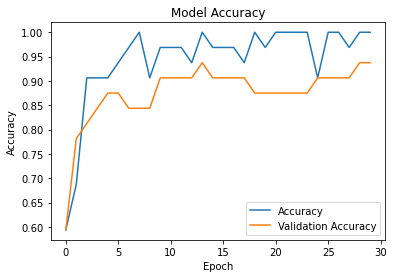

In [18]:
# plot graph
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

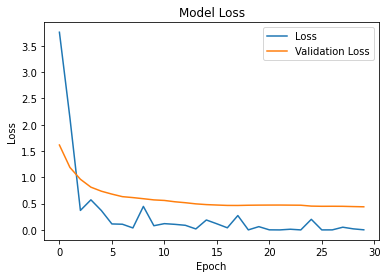

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [20]:
# save the model for future use
model.save('cnn_vgg16')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_vgg16\assets
